In [ ]:
# comments are mine

In [ ]:
!pip install rdkit-pypi

In [ ]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

In [ ]:
import pandas as pd
pd.set_option('display.max_columns',None)
import numpy as np

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/bcrabl_ic50.csv')

In [ ]:
# df

# Feature engineering

## Canonical SMILES generation

In [ ]:
# def canonical_smiles(smiles):
#    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
#    canonical_smiles = [Chem.MolToSmiles(mol) for mol in mols]
#    return canonical_smiles

# df['canonical'] = canonical_smiles(df['smiles'])

In [ ]:
# len(df['canonical'])

In [ ]:
# df

## Duplicate handling

In [ ]:
# #calculate duplicates

# duplicate = df[df['canonical'].duplicated()]['canonical'].values
# len(duplicate)

In [ ]:
# # see/list duplicates

# df[df['canonical'].isin(duplicate)].sort_values(by='canonical')

In [ ]:
# #drop duplicates

# df = df.drop_duplicates(subset='canonical')
# df

## Descriptor calculation (RDKit)

In [ ]:
# #define function

# def RDkit_descriptors(smiles):
#     mols = [Chem.MolFromSmiles(i) for i in smiles]
#     calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
#     desc_names = calc.GetDescriptorNames()

#     Mol_descriptors =[]
#     for mol in mols:
#         # add hydrogens to molecules
#         mol=Chem.AddHs(mol)
#         # Calculate all 200 descriptors for each molecule
#         descriptors = calc.CalcDescriptors(mol)
#         Mol_descriptors.append(descriptors)
#     return Mol_descriptors,desc_names

In [ ]:
# #function calling

# Mol_descriptors,desc_names = RDkit_descriptors(df['canonical'])

In [ ]:
# descriptor_200 = pd.DataFrame(Mol_descriptors,columns=desc_names)

In [ ]:
# descriptor_200

In [ ]:
# descriptor_200.to_excel('/content/drive/MyDrive/descriptor_200.xlsx', index=False)

In [ ]:
# df.to_excel('/content/drive/MyDrive/bcrabl_ic50_cleaned.xlsx', index=False)

## Train-test split

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('./5_bcrabl_ic50_cleaned.csv')

print(df.head())
print(df.info())
print(df.describe())

              id      mw  logp  \
0  CHEMBL3929105  581.37  2.51   
1  CHEMBL3973189  500.32  3.06   
2  CHEMBL3953682  530.71  3.33   
3     CHEMBL1421  488.02  3.31   
4  CHEMBL2375973  512.61  5.26   

                                              smiles      ic50 unit  \
0  O=[N+]([O-])c1cc(C(F)(F)F)ccc1S(=O)(=O)N1CCN(c...  0.000021   nM   
1  O=C(c1ccc(C(F)(F)F)cc1)N1CCN(c2nc(N3CCOCC3)ncc...  0.000024   nM   
2  O=[N+]([O-])c1cc(C(F)(F)F)ccc1S(=O)(=O)N1CCN(c...  0.000023   nM   
3  Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...  1.000000   nM   
4  CCN(CC)CCOc1ccc(NC(=O)c2ccc(OC)c(Nc3nccc(-c4cc...  1.480000   nM   

                                           canonical  MaxEStateIndex  \
0  O=[N+]([O-])c1cc(C(F)(F)F)ccc1S(=O)(=O)N1CCN(c...       14.079246   
1  O=C(c1ccc(C(F)(F)F)cc1)N1CCN(c2nc(N3CCOCC3)ncc...       13.771746   
2  O=[N+]([O-])c1cc(C(F)(F)F)ccc1S(=O)(=O)N1CCN(c...       13.759629   
3  Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...       13.560621   
4  CCN(C

In [ ]:
X = df.drop(columns=['ic50', 'id', 'smiles', 'unit', 'canonical'])
y = df['ic50']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training data shape: (476, 210)
Testing data shape: (120, 210)
Training labels shape: (476,)
Testing labels shape: (120,)


## Scaling

In [ ]:
# Rio: should we check outliers before scaling?

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
X_train_scaled = scaler.fit_transform(X_train) # fit and transform the training dataset
X_test_scaled = scaler.transform(X_test) # only transform the test set

In [ ]:
print(f"Transformed Training data shape: {X_train.shape}")
print(f"Transformed Testing data shape: {X_test.shape}")

Transformed Training data shape: (476, 210)
Transformed Testing data shape: (120, 210)


## Feature analysis: Clustering

In [ ]:
from sklearn.cluster import DBSCAN

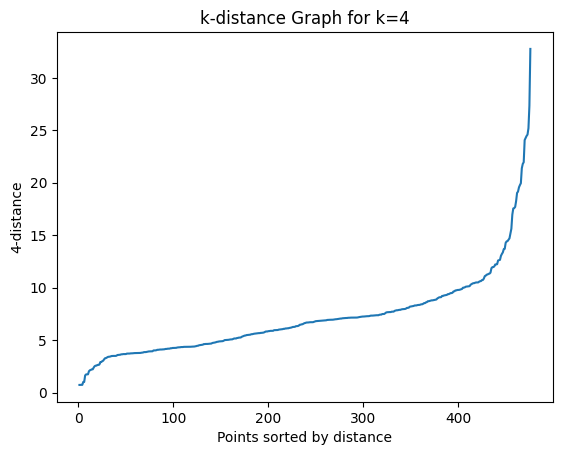

In [ ]:
# k-distance graph to find a proper 'eps' for DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

k = 4

neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(X_train_scaled)
distances, indices = nbrs.kneighbors(X_train_scaled)

k_distances = np.sort(distances[:, k-1])

plt.plot(range(1, len(k_distances) + 1), k_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-distance')
plt.title(f'k-distance Graph for k={k}')
plt.show()

In [ ]:
# Apply DBSCAN --> elbow as eps = 10
dbscan = DBSCAN(eps=10, min_samples=5)
clusters = dbscan.fit_predict(X_train_scaled)

unique_labels = set(clusters)
n_clusters = len(unique_labels) - (1 if -1 in clusters else 0)
n_noise_points = list(clusters).count(-1)
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise_points}")

Number of clusters: 5
Number of noise points: 57


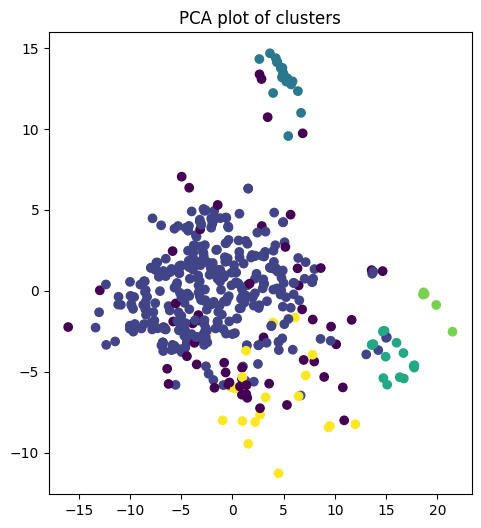

In [ ]:
# Visualization of clusters
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2) # reduce to PCA for easier visualization
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters)
plt.title('PCA plot of clusters')

plt.show()

## Training 1: Best Model Determination

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
from sklearn.model_selection import train_test_split

# Separate noise and non-noise data
is_noise = (clusters == -1)
X_noise = X_train_scaled[is_noise]

#noise is being left alone for now

In [ ]:
### Linear Regression ### --> Baseline Model

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

model = LinearRegression()
model.fit(X_train_scaled, y_train)

from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2_lr= r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"LR R^2 Score: {r2_lr:.2f}")

Mean Squared Error: 559114966924419652361650176.00
LR R^2 Score: -151982652394754944.00


In [ ]:
### Random Forest ###
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train_scaled, y_train)

from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2_rf = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"RF R^2 Score: {r2_rf:.2f}")

Mean Squared Error: 9147107581.97
RF R^2 Score: -1.49


In [ ]:
### SVM-R (SVR) ###
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVR())
])

svm_pipeline.fit(X_train_scaled, y_train)

y_pred_svm = svm_pipeline.predict(X_test_scaled)
mse_svm = mean_squared_error(y_test, y_pred_svm)
r2_svm = r2_score(y_test, y_pred_svm)
print(f"SVM Mean Squared Error: {mse_svm:.2f}")
print(f"SVM R^2 Score: {r2_svm:.2f}")

SVM Mean Squared Error: 4023167242.53
SVM R^2 Score: -0.09


In [ ]:
### XGBoost ###
import xgboost as xgb
from sklearn.metrics import mean_squared_error

dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# Params
params = {
    'objective': 'reg:squarederror', # Regression with squared loss
    'max_depth': 6,                  # Maximum depth of a tree
    'eta': 0.3,                      # Learning rate
    'subsample': 0.8,                # Subsample ratio of the training instances
    'colsample_bytree': 0.8,         # Subsample ratio of columns when constructing each tree
    'seed': 42                       # Random seed for reproducibility
}

bst = xgb.train(params, dtrain, num_boost_round=100)

y_pred_xgb = bst.predict(dtest)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGB R^2 Score: {r2_xgb:.2f}")
print(f"XGBoost Mean Squared Error: {mse_xgb:.2f}")

XGB R^2 Score: -11.99
XGBoost Mean Squared Error: 47775799600.63


In [ ]:
### MLP ###

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
])

In [ ]:
# Train
mlp_pipeline.fit(X_train_scaled, y_train)

y_pred_mlp = mlp_pipeline.predict(X_test_scaled)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)
print(f"MLP Mean Squared Error: {mse_mlp:.2f}")
print(f"MLP R^2 Score: {r2_mlp:.2f}")

MLP Mean Squared Error: 5330542890.14
MLP R^2 Score: -0.45


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Conclusion: SVM and MLP is slightly better than the rest

## RFE

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

estimator = LinearRegression() # can be experimented upon

rfe = RFE(estimator=estimator, n_features_to_select=50)  # 'n' can be experimented upon

In [ ]:
rfe.fit(X_train, y_train)

print("Selected Features: %s" % list(X_train.columns[rfe.support_]))
print("Feature Ranking: %s" % list(rfe.ranking_))

Selected Features: ['NumValenceElectrons', 'Chi0n', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7', 'SlogP_VSA8', 'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA8', 'EState_VSA9', 'HeavyAtomCount', 'NumHDonors', 'NumHeteroatoms', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_halogen', 'fr_nitrile']
Feature Ranking: [66, 65, 49, 90, 50, 94, 83, 16, 27, 17, 1, 138, 45, 43, 46, 44, 69, 67, 68, 113, 92, 109, 99, 88, 116, 118, 85, 111, 123, 51, 1, 25, 77, 18, 14, 75, 74, 80, 79, 81, 82, 112, 124, 120, 106, 107, 13, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 147, 1, 1, 1,

## New DataFrame

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

selected_features = X_train.columns[rfe.support_]

# Memastikan selected_features adalah array 1 dimensi dengan 50 elemen
print(f"Jumlah selected_features: {len(selected_features)}")
print(f"Jumlah kolom X_train_scaled: {X_train_scaled.shape[1]}")

# Mendapatkan list kolom yang tidak ada di selected_features
columns_to_drop = [col for col in X_train.columns if col not in selected_features]

# Mendrop kolom-kolom tersebut dari X_train dan X_test
X_train = X_train.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)

# Menskalakan X_train dan X_test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Memastikan X_train_scaled dan X_test_scaled memiliki ukuran yang benar
print(f"Ukuran X_train_scaled: {X_train_scaled.shape}")
print(f"Ukuran X_test_scaled: {X_test_scaled.shape}")

# Mengubah hasil skala menjadi DataFrame dengan kolom-kolom yang dipilih
X_train_final = pd.DataFrame(X_train_scaled, columns=selected_features)
X_test_final = pd.DataFrame(X_test_scaled, columns=selected_features)

Jumlah selected_features: 50
Jumlah kolom X_train_scaled: 210
Ukuran X_train_scaled: (476, 50)
Ukuran X_test_scaled: (120, 50)


In [ ]:
print("First few rows of the Transformed and Scaled Training set:\n", X_train_final.head())
print("First few rows of the Transformed and Scaled Testing set:\n", X_test_final.head())

First few rows of the Transformed and Scaled Training set:
    NumValenceElectrons     Chi0n  PEOE_VSA1  PEOE_VSA10  PEOE_VSA11  \
0            -0.709204 -1.188390  -0.596082   -1.045510    1.267293   
1            -0.970339 -0.680108  -0.819652   -0.244998   -1.110783   
2             0.270049  0.568863   1.942622    0.536879    0.974454   
3            -0.317503  0.592714   0.086423    0.648271   -0.817944   
4             0.139482 -0.162644  -1.561443    1.594679    0.646212   

   PEOE_VSA12  PEOE_VSA13  PEOE_VSA14  PEOE_VSA2  PEOE_VSA3  PEOE_VSA4  \
0   -0.805413    0.058171    0.724013  -0.075365  -1.463325   1.396960   
1   -0.805413    1.512595   -0.971368   0.804471  -0.685194  -1.083662   
2   -0.805413    1.512595   -0.971368   0.824695  -1.463325  -0.391382   
3    0.447662   -1.396253   -0.971368   0.824252  -1.463325  -1.083662   
4   -0.805413   -1.396253    0.724013  -0.995648   1.133112   1.396960   

   PEOE_VSA5  PEOE_VSA6  PEOE_VSA7  PEOE_VSA8  PEOE_VSA9  SMR_VSA1  

## PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)  # can be changed

In [ ]:
X_train_pca = pca.fit_transform(X_train_scaled)
print(f'Number of components selected: {pca.n_components_}') # inspect number of components

Number of components selected: 21


In [ ]:
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Total Explained Variance: {pca.explained_variance_ratio_.sum()}")

Explained Variance Ratio: [0.20994579 0.10935928 0.09780272 0.08050155 0.06696448 0.05871687
 0.04586245 0.03860792 0.03555938 0.03088196 0.0274602  0.02255915
 0.02037186 0.01739544 0.01613524 0.01570296 0.01388227 0.01267711
 0.01125673 0.01014167 0.00882258]
Total Explained Variance: 0.9506076158898933


In [ ]:
import pandas as pd
from sklearn.decomposition import PCA

# Misalkan X_train_scaled sudah diskalakan dan memiliki kolom asli
columns_original = X_train.columns

# Melakukan PCA pada data yang sudah diskalakan
pca = PCA(n_components=0.95)  # Sesuaikan dengan jumlah komponen yang diinginkan
X_train_pca = pca.fit_transform(X_train_scaled)

# Membuat DataFrame dari hasil PCA dengan nama kolom yang sesuai
component_names = [f'PC{i+1}' for i in range(pca.n_components_)]
X_train_pca_df = pd.DataFrame(X_train_pca, columns=component_names)

# Menampilkan jumlah komponen yang dipilih dan beberapa baris dari DataFrame baru
print(f'Number of components selected: {pca.n_components_}')
print(X_train_pca_df.head())

# Melihat kontribusi kolom asli terhadap komponen utama
pca_components_df = pd.DataFrame(pca.components_, columns=columns_original, index=component_names)
print(pca_components_df)

# Variansi yang dijelaskan oleh masing-masing komponen
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by component: {explained_variance}')

Number of components selected: 21
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  2.039478  0.621690  3.191975 -2.141677 -0.101607 -1.968826 -0.704987   
1  3.109550 -3.524819 -0.122960  1.380945  0.187717  1.459321 -0.930669   
2  0.484696 -0.687835 -2.913762 -3.372904 -0.091964  1.388206  2.219863   
3  1.362331 -2.254371 -2.208715  0.166014 -2.069524  1.240866  1.430382   
4  0.257392  0.545962  1.574950  0.863090  2.490869 -3.141411  1.902527   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -1.051962 -1.099825  1.695829 -0.874367  0.280884  0.079126  0.413085   
1 -1.595017 -0.747184  0.299771 -0.101418  0.146767  0.043279 -0.174271   
2 -1.993127  0.635194  1.342767 -1.263938 -0.402548  1.870157 -0.665962   
3  0.101562 -0.784126 -1.202908  0.450029  0.557647  1.047667 -1.404221   
4  0.641123 -0.549094  0.306088 -2.630411  1.767102 -1.348373 -2.056035   

       PC15      PC16      PC17      PC18      PC19      PC20   

## New DataFrame

In [ ]:
import pandas as pd

X_train_pca_df = pd.DataFrame(X_train_pca)  # Create DataFrame from the PCA-transformed training set
X_test_pca_df = pd.DataFrame(X_test_pca)    # Create DataFrame from the PCA-transformed testing set

# Add column names
n_components = X_train_pca.shape[1]
X_train_pca_df.columns = [f'PC{i+1}' for i in range(n_components)]
X_test_pca_df.columns = [f'PC{i+1}' for i in range(n_components)]

X_train_pca_df['ic50'] = y_train.reset_index(drop=True)
X_test_pca_df['ic50'] = y_test.reset_index(drop=True)

In [ ]:
X_test_pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,ic50
0,3.616395,-0.207237,5.524081,1.654419,-0.161287,1.279779,-0.544880,1.144090,0.612790,1.196933,-0.594990,-0.547969,-0.416289,-1.175866,-0.798765,-1.237686,0.012166,0.410388,-0.567806,-0.357673,0.317032,20000.00
1,0.533475,1.310766,-1.979003,3.538443,-0.423482,1.248341,0.860152,-0.935847,1.035018,-1.015111,0.346961,0.574502,1.471622,-2.389591,-0.999441,-1.934279,1.087005,-1.022236,-1.420393,-0.011538,1.678287,320.00
2,1.942377,0.249868,0.534504,-4.772802,0.364757,0.283454,-1.028525,-1.271638,-0.808241,1.369601,-0.505648,-0.028622,-0.279198,-0.406704,-0.547124,0.910920,0.171726,0.078661,0.110164,-0.590106,-0.660172,100000.00
3,-3.027693,3.485090,0.919090,-0.381391,-2.261693,-0.640742,0.576336,1.750421,-0.089730,-1.762472,0.323424,0.555375,0.755072,-1.185718,0.233178,1.433662,-0.356739,-1.530032,1.019647,0.647090,0.226876,41.50
4,1.532084,1.699130,3.694993,-2.488740,-0.519006,-0.839070,-0.051748,-1.114814,-1.032820,1.209817,-0.513264,0.496326,-0.591361,0.276966,1.001614,-0.662951,0.704005,-0.227042,0.267828,-1.630401,1.167466,1420.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2.198123,-0.376200,-2.771071,-0.877153,0.380422,-0.617179,1.794315,1.593116,-0.866000,-1.361626,-3.363227,1.457285,-2.029800,-0.309297,-0.107881,0.287356,-0.712222,-0.571052,-1.497391,1.415586,-0.061749,10000.00
116,-1.459517,4.864633,0.234314,-3.281959,0.126312,1.898722,0.515684,2.254599,-0.922834,-1.477075,2.036331,0.599987,0.898433,-1.651796,1.188482,0.268807,0.226225,-1.136002,1.189230,0.269993,-1.093379,199.86
117,-3.451756,0.591542,-3.122226,1.312854,-2.696552,-1.577096,0.311715,0.806361,-0.386924,-0.752960,0.209601,-2.262428,-1.469075,0.153498,-1.003163,-0.355429,0.490047,-0.867626,-0.417956,-0.283361,-0.273708,10000.00
118,-3.616911,-1.206345,-1.021245,2.381982,-2.047836,0.060214,-0.863105,-0.502436,-0.273572,0.128237,-0.916560,1.007424,0.162136,1.213887,-0.180940,-0.026451,-0.964432,-0.007006,-0.428499,0.117647,-0.219209,10000.00


In [ ]:
# X_train_pca_df.to_csv('X_train_pca.csv', index=False)
# X_test_pca_df.to_csv('X_test_pca.csv', index=False)

In [ ]:
# from google.colab import files
# files.download('X_train_pca.csv')

In [ ]:
# files.download('X_test_pca.csv')

## Training 2: Final Model

In [ ]:
### SVM-R (SVR) - Training 2 ###
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

svm_pipeline = Pipeline([
    ('svm', SVR())
])

svm_pipeline.fit(X_train_pca, y_train)

y_pred_svm = svm_pipeline.predict(X_test_pca)
mse_svm = mean_squared_error(y_test, y_pred_svm)
r2_svm = r2_score(y_test, y_pred_svm)
print(f"SVM Mean Squared Error: {mse_svm:.2f}")
print(f"SVM R^2 Score: {r2_svm:.2f}")

SVM Mean Squared Error: 4023118889.48
SVM R^2 Score: -0.09


In [ ]:
### MLP - Training 2 ###

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

mlp_pipeline = Pipeline([
    ('mlp', MLPRegressor(max_iter=2500, random_state = 43, activation = 'relu', solver = 'adam', learning_rate = 'adaptive'))
])

# Train
mlp_pipeline.fit(X_train_pca, y_train)

y_pred_mlp = mlp_pipeline.predict(X_test_pca)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)
print(f"MLP Mean Squared Error: {mse_mlp:.2f}")
print(f"MLP R^2 Score: {r2_mlp:.2f}")

MLP Mean Squared Error: 3379114831.74
MLP R^2 Score: 0.08


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


HYPERPARAMETER TUNING:

- Alpha (L2 Regularisasi) = (0.0001, 0.001, 0.01, 0.1, 0.5, 1)
- Learning rate: constant
- Learning rate initialitation = (0.001, 0.01, 0.1, 0.5, 1, 1.5, 2)
- Solver (Weight Optimization): adam
- Max_iter(epoch) = (50, 100, 150, 200)


In [ ]:
mlp = MLPRegressor()
L2_Reg_list = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 1.5, 2]

L2_Reg = []
r2_scores = []

for reg in L2_Reg_list:
    mlp = MLPRegressor(alpha=reg, random_state=42).fit(X_train_pca, y_train)
    r2 = r2_score(y_test, mlp.predict(X_test_pca))
    r2_scores.append(r2)
    L2_Reg.append(reg)

#create dataset eta
df_reg = pd.DataFrame({'L2 Regularization': L2_Reg, 'r2_score': r2_scores})

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(data=df_reg, x= df_reg['L2 Regularization'], y= df_reg['r2_score'])
plt.title('Tuning L2 Regularization MLP')
plt.show()

In [ ]:
mlp = MLPRegressor()
epoch_list = [200, 250, 500, 1000, 2000, 2500, 3000, 5000]

epoch = []
r2_scores = []

for e in epoch_list:
    mlp = MLPRegressor(max_iter = e, random_state=42).fit(X_train_pca, y_train)
    r2 = r2_score(y_test, mlp.predict(X_test_pca))
    r2_scores.append(r2)
    epoch.append(e)

df_epoch = pd.DataFrame({'epoch': epoch, 'r2_score': r2_scores})

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(data=df_epoch, x= df_epoch['epoch'], y= df_epoch['r2_score'])
plt.title('Tuning epoch MLP')
plt.show()

In [ ]:
df_epoch

In [ ]:
mlp = MLPRegressor()
eta_list = [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5, 2]

eta = []
r2_scores = []

for etaa in eta_list:
    mlp = MLPRegressor(learning_rate_init = etaa, random_state=42).fit(X_train_pca, y_train)
    r2 = r2_score(y_test, mlp.predict(X_test_pca))
    r2_scores.append(r2)
    eta.append(etaa)

df_eta = pd.DataFrame({'Learning Rate': eta, 'r2_score': r2_scores})

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(data=df_eta, x= df_eta['Learning Rate'], y= df_eta['r2_score'])
plt.title('Tuning eta MLP')
plt.show()

In [ ]:
mlp = MLPRegressor()
hidden_layer_list = [100, 200, 250, 500, 1000, 1500, 2000, 5000, 10000, 15000, 20000]

hidden_layer = []
r2_scores = []

for hl in hidden_layer_list:
    mlp = MLPRegressor(hidden_layer_sizes = hl, random_state=42, activation = 'relu', solver = 'adam').fit(X_train_pca, y_train)
    r2 = r2_score(y_test, mlp.predict(X_test_pca))
    r2_scores.append(r2)
    hidden_layer.append(hl)

df_hl = pd.DataFrame({'Hidden Layer': hidden_layer, 'r2_score': r2_scores})

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(data=df_hl, x= df_hl['Hidden Layer'], y= df_hl['r2_score'])
plt.title('Tuning hidden layer MLP')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Inisialisasi MLPRegressor
mlp = MLPRegressor(
    random_state=42,
    activation='relu',
    learning_rate='constant',
    solver='adam',
    learning_rate_init=0.01,
    alpha=0.01
)

# parameter grid
param_grid = {
    'hidden_layer_sizes': [(6000,), (8000,), (10000,), (12000,)],
    'max_iter': [2000, 2300, 2500, 2700],
}

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)

# Fit grid search ke data pelatihan
grid_search.fit(X_train_pca, y_train)

# Mendapatkan parameter terbaik
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Prediksi menggunakan model terbaik
best_mlp = grid_search.best_estimator_
predict_test = best_mlp.predict(X_test_pca)
r2_score_test = r2_score(y_test, predict_test)

print('r2 score test:', r2_score_test)

## Save Model

In [ ]:
# Save Model Pipeline --> MLP

# from rdkit.Chem import AllChem
# from rdkit import Chem
# from rdkit.Chem import Descriptors
# from rdkit.ML.Descriptors import MoleculeDescriptors
# import pandas as pd
# pd.set_option('display.max_columns',None)
# import numpy as np
# from sklearn.neural_network import MLPRegressor
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import mean_squared_error, r2_score
# import joblib
# from google.colab import files

# # Canonical SMILES generation
# def canonical_smiles(smiles):
#    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
#    canonical_smiles = [Chem.MolToSmiles(mol) for mol in mols]
#    return canonical_smiles

# df['canonical'] = canonical_smiles(df['smiles'])

# # Descriptor calculation
# def RDkit_descriptors(smiles):
#     mols = [Chem.MolFromSmiles(i) for i in smiles]
#     calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
#     desc_names = calc.GetDescriptorNames()

#     Mol_descriptors =[]
#     for mol in mols:
#         # add hydrogens to molecules
#         mol=Chem.AddHs(mol)
#         # Calculate all 200 descriptors for each molecule
#         descriptors = calc.CalcDescriptors(mol)
#         Mol_descriptors.append(descriptors)
#     return Mol_descriptors,desc_names

# Mol_descriptors,desc_names = RDkit_descriptors(df['canonical'])

# mlp_pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('mlp', MLPRegressor(hidden_layer_sizes=(10000,), max_iter=2500, random_state=42, activation='relu', learning_rate='adam', solver='adam', learning_rate_init=0.01, alpha=0.01))
# ])

# mlp_pipeline.fit(X_train, y_train)

# # Predict and evaluate
# y_pred_mlp = mlp_pipeline.predict(X_test)
# mse_mlp = mean_squared_error(y_test, y_pred_mlp)
# r2_mlp = r2_score(y_test, y_pred_mlp)
# print(f"MLP Mean Squared Error: {mse_mlp:.2f}")
# print(f"MLP R^2 Score: {r2_mlp:.2f}")

# # Save the model to a file
# joblib.dump(mlp_pipeline, 'project4.pkl')

# # Download the model file
# files.download('project4.pkl')